## Decision trees and ensemble learning algorithms

- This week we learned about decision trees, which are powerful algorithms capable of fitting complex datasets and make predictions based on if/else statements by splitting a node into 2 or more sub-nodes.
- We covered gradient boosting using xgboost.
- Other learning areas this week included, but not limited to:
    - Hyperparameter tuning in decision tree training models
    - Random forests and tuning them.
    
    
- In this homework, we will use the California Housing Prices dataset to create a regression model for predicting housing prices (column 'median_house_value').


In [25]:
# import the libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import re

import warnings
warnings.filterwarnings("ignore")

## Loading the data

- The following columns only will be used: 'latitude','longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value','ocean_proximity'

- Handle missing values
- Split the data into train, validation and test sets
- Apply DictVectorizer

In [2]:
# Fetching the data
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
columns = ['latitude','longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value','ocean_proximity']

df = pd.read_csv(url, usecols=columns)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Preparing the data 

# dealing with missing values

df['total_bedrooms'] = df['total_bedrooms'].fillna(0)

# train and test split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# train and validation split
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# Resetting the indices 
df_train.reset_index(drop=True)
df_test.reset_index(drop=True)
df_val.reset_index(drop=True)

# Getting the y variables
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

# Removing the target variable
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


In [5]:
# One-hot encoding the categorical feature using DictVectorizer
train_dict = df_train.to_dict(orient='records')

# Creating an instance of DictVectorizer
dv = DictVectorizer(sparse=False)

# Fitting and transforming the dictionary
X_train = dv.fit_transform(train_dict)

# Doing the same on validation set (transforming only)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

- Train a decision tree regressor to predict the median_house_value variable
- Which feature is used for splitting the data

In [6]:
# training the decision tree

dt_reg = DecisionTreeRegressor(max_depth=1)
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
# Getting the feature used to split

print(export_text(dt_reg, feature_names = dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



### Feature used: ocean_proximity=INLAND

## Question 2
- Train a random forest model with these parameters:

    - n_estimators=10
    - random_state=1
    - n_jobs=-1 (optional - to make training faster)
    
- What's the RMSE of this model on validation?



In [8]:
rf_reg = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [9]:
# Calculating the RMSE

y_pred = rf_reg.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
print('RMSE:', np.sqrt(mse).round(2))

RMSE: 0.25


### RMSE of the model on validation: 0.25

## Question 3
- Tuning n_estimators:
    - Try different values of n_estimator parameter from 10 to 200 with step 10.
    - Evaluate the model on the validation dataset.
    - After which value of n_estimators does RMSE stop improving?

In [10]:
scores = []

for n in range(10, 201, 10):
    rf_reg = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse).round(2)
    
    scores.append((n, rmse))

In [11]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.25
1,20,0.24
2,30,0.24
3,40,0.23
4,50,0.23
5,60,0.23
6,70,0.23
7,80,0.23
8,90,0.23
9,100,0.23


### RMSE stops improving at n_estimators = 10

## Question 4

- Tuning max_depth:
    - Try different values of max_depth: [10, 15, 20, 25]
    - For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
    - What's the best max_depth

In [12]:
scores = []

for max_d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf_reg = RandomForestRegressor(n_estimators=n, 
                                       max_depth=max_d, 
                                       n_jobs=-1, 
                                       random_state=1)
        rf_reg.fit(X_train, y_train)

        y_pred = rf_reg.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse).round(2)

        scores.append((n, max_d, rmse))

In [13]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])
df_scores.head(10)

,n_estimators,max_depth,rmse
0,10,10,0.25
1,20,10,0.25
2,30,10,0.25
3,40,10,0.25
4,50,10,0.25
5,60,10,0.25
6,70,10,0.25
7,80,10,0.25
8,90,10,0.25
9,100,10,0.25


### Best max_depth = 10

## Question 5

- Extract the feature importance info using feature_importances_ field from scikit-learn
- Train the model with these parametes:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)
- Get the feature importance information from this model
- What's the most important feature?


In [18]:
# Training the model
regr = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
regr.fit(X_train, y_train)

# Getting the most important features
regr.feature_importances_


array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

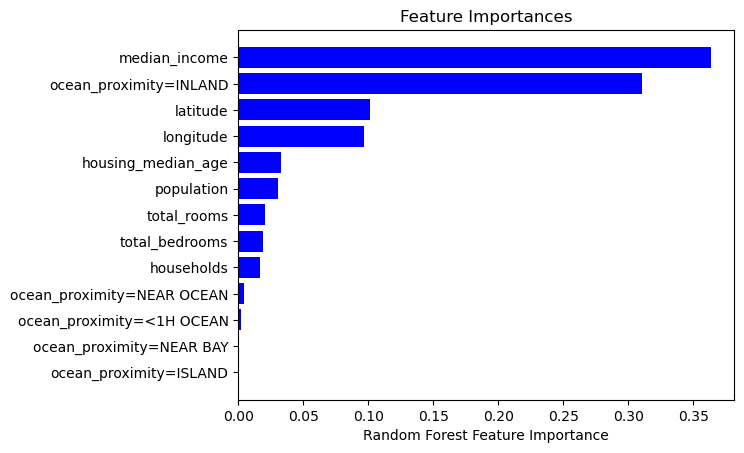

In [19]:
# Plotting the feature importance for easier interpretability

features = dv.get_feature_names()
importances = regr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Random Forest Feature Importance')
plt.show()

### Most important feature: median_income

## Question 6

- Now let's train an XGBoost model! Tuning the eta parameter:
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:
```
    xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
    
- Now change eta from 0.3 to 0.1.

- Which eta leads to the best RMSE score on the validation dataset?

In [27]:
# Wrapping the training in DMatrix
features = dv.get_feature_names()

# removing [, ] or < from feature names
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

# creating the DMatrix
train_data = xgb.DMatrix(X_train, label=y_train, feature_names=features)
val_data = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [28]:
# training the model

xgb_params = {
  'eta': 0.3, 
  'max_depth': 6,
  'min_child_weight': 1,

  'objective': 'reg:squarederror',
  'nthread': 8,

  'seed': 1,
  'verbosity': 1,
}

xreg = xgb.train(xgb_params, train_data, num_boost_round=100)

In [29]:
# predictions on eta = 0.3

y_pred = xreg.predict(val_data)

mse = mean_squared_error(y_val, y_pred)
print('RMSE:', np.sqrt(mse).round(2))

RMSE: 0.23


In [30]:
# Tuning the learning_rate (eta)

xgb_params = {
  'eta': 0.1, 
  'max_depth': 6,
  'min_child_weight': 1,

  'objective': 'reg:squarederror',
  'nthread': 8,

  'seed': 1,
  'verbosity': 1,
}

xreg = xgb.train(xgb_params, train_data, num_boost_round=100)

In [31]:
# predictions on eta = 0.1

y_pred = xreg.predict(val_data)

mse = mean_squared_error(y_val, y_pred)
print('RMSE:', np.sqrt(mse).round(2))

RMSE: 0.23


### eta leading to the best RMSE score = Both gives same